<a href="https://colab.research.google.com/github/Vihaan3/Custom-Search-Engine-Demo/blob/main/Karpathy_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F

### Makemore Part 1

In [ ]:
words = open('/content/names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
g = torch.Generator().manual_seed(2147483647)

#### A pared down version of the neural network in the original video.

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

print(loss.item())

3.7686190605163574
2.696505546569824
2.5822560787200928
2.5413522720336914
2.52126407623291
2.509854555130005
2.5027060508728027
2.4978790283203125
2.4944381713867188
2.4918932914733887
2.4901304244995117


In [ ]:
for i in range(5):

  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


Loss: 2.49

Text Generated:
- junide.
- janasah.
- p.
- cfay.
- a.

#### E01: Trigram
I wasn't sure at first whether increasing the right way to go was increasing the size of the input dimension or adding another dimension so I decided to try both. Also, note that my code here is meant to resemble Andrej Karpathy's, which is intentonally a little bit hacky for educational purposes. This is not what a "production" implementation would look like.

##### V1: Additional Dimension

In [ ]:
import einops

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.', '.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append((ix1, ix2))
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement() // 2 # dividing by 2 now because the shape of xs has changed
print('number of examples: ', num)

W1 = torch.randn((27, 27, 27), generator=g, requires_grad=True) # 3D now

number of examples:  228146


In [ ]:
for k in range(100):

  # forward pass
  xenc = F.one_hot(xs[:, 0], num_classes=27).float() # character 1
  xenc2 = F.one_hot(xs[:, 1], num_classes=27).float() # character 2
  logits = einops.einsum(xenc, W1, xenc2, "b i, i j k, b j -> b k") # you might have to ask GPT about this line. Understand what's happening but don't stress it, it'll make more sense soon.
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W1**2).mean()

  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W1.grad = None # set to zero the gradient
  loss.backward()

  # update
  W1.data += -50 * W1.grad

print(loss.item())

3.6517415046691895
2.8801517486572266
2.6203973293304443
2.471735715866089
2.373619794845581
2.3028182983398438
2.2486462593078613
2.205559015274048
2.1703648567199707
2.1410269737243652
2.1184768676757812


In [ ]:
for i in range(5):

  out = []
  # couldn't decide on good var names so I thought I would be funny
  uno = 0
  dos = 0
  while True:

    xenc = F.one_hot(torch.tensor(uno), num_classes=27).float().unsqueeze(0)
    xenc2 = F.one_hot(torch.tensor(dos), num_classes=27).float().unsqueeze(0)
    logits = einops.einsum(xenc, W1, xenc2, "b i, i j k, b j -> b k")
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    uno = dos
    dos = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[dos])
    if dos == 0:
      break
  print(''.join(out))

ni.
makestobfzwruvbvjxpxdznleanczqwmdemyw.
mkzdnseira.
na.
umjoebvsdfyhoujfodpmvuhdgdohupy.


Loss: 2.12

Text Generated
- coud
- qipny
- hafijcpydhrdqzieqiupfdcaanvinegnhiyah
- dae
- hatea

Lower loss but also lower quality outputs than the original. Seems like overfitting.

Curiously, when I train for 1000 steps instead, I get these results:

Loss: 1.49

Text Generated
- ouwade
- ilyasid
- prelay
- ocnzi
- ohr

These seem much higher quality than the original.  

##### V2: Bigger input dimension

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.', '.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append((ix1, ix2))
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement() // 2 # dividing by 2 now because the shape of xs has changed
print('number of examples: ', num)

W2 = torch.randn((27*2, 27), generator=g, requires_grad=True) # still 2D but now the input dimension is double

number of examples:  228146


In [ ]:
for k in range(100):

  # forward pass
  '''Edit: a cleaner implementation would be:
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc.view(-1, 27*2) @ W2
  '''
  xenc = F.one_hot(xs[:, 0], num_classes=27).float() # character 1
  xenc2 = F.one_hot(xs[:, 1], num_classes=27).float() # character 2
  xcat = torch.cat ((xenc, xenc2), 1)
  logits = xcat @ W2
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W2**2).mean()

  if k % 10 == 0:
    print(loss.item())

  # backward pass
  W2.grad = None # set to zero the gradient
  loss.backward()

  # update
  W2.data += -50 * W2.grad

print(loss.item())

4.5374555587768555
2.16996693611145
2.063832998275757
2.020979404449463
1.9984627962112427
1.9848086833953857
1.9757133722305298
1.9692426919937134
1.9644166231155396
1.960689663887024
1.958001732826233


In [ ]:
for i in range(5):

  out = []
  # couldn't decide on good var names so I thought I would be funny
  uno = 0
  dos = 0
  while True:

    xenc = F.one_hot(torch.tensor(uno), num_classes=27).float().unsqueeze(0)
    xenc2 = F.one_hot(torch.tensor(dos), num_classes=27).float().unsqueeze(0)
    xcat = torch.cat((xenc, xenc2), 1)
    logits = xcat @ W2
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    uno = dos
    dos = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[dos])
    if dos == 0:
      break
  print(''.join(out))

.
.
mefilayniylenn.
.
.


Loss: 1.95

Text Generated:
- blank
- dena
- blank
- blank
- blank

Much lower loss but also lower quality generations.

#### E02: Splitting
Basic implementation of the splitting. Play around by yourself to answer Andrej Karpathy's question.

In [ ]:
import random

random.shuffle(words)

num_words = len(words)
train_split = int(0.8*num_words)
dev_split = int(0.9*num_words)

train_words = words[:train_split]
dev_words = words[train_split:dev_split]
test_words = words[dev_split:]

print(f"Train Size: {len(train_words)}")
print(f"Dev Size: {len(dev_words)}")
print(f"Test Size: {len(test_words)}")

Train Size: 25626
Dev Size: 3203
Test Size: 3204


#### E05: F.cross_entropy


In [ ]:
# From the original. You can turn snippet 1 into snippet 2 using F.cross_entropy
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

# F.cross_entropy
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
loss = F.cross_entropy(logits, ys) + 0.01*(W**2).mean()

# Why you want to use F.cross_entropy instead: https://youtu.be/TCH_1BHY58I?t=1979

### Makemore Part 2: MLP

#### E03

### Makemore Part 3: Activations and Gradients, Batchnorm

Not bothering too much with splits here for convenience.

#### Setup

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [ ]:
X, Y = [], []
block_size = 3
n_embd = 10
n_hidden = 100
block_size = 3
vocab_size = len(itos)

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


#### E01

In [ ]:
# MLP Setup
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
C = torch.randn((vocab_size, n_embd),            generator=g)
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True
  p.data = torch.zeros_like(p.data)

47024


In [ ]:
# MLP Training
batch_size = 32
ud = []
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
  Xb, Yb = X[ix], Y[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  if i % 100 == 0:
    print(loss.item())

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

3.295837163925171
3.044875144958496
2.9702932834625244
2.840195894241333
3.0619606971740723
2.819377899169922
3.093287467956543
2.6854422092437744
2.6405556201934814
2.8148913383483887


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

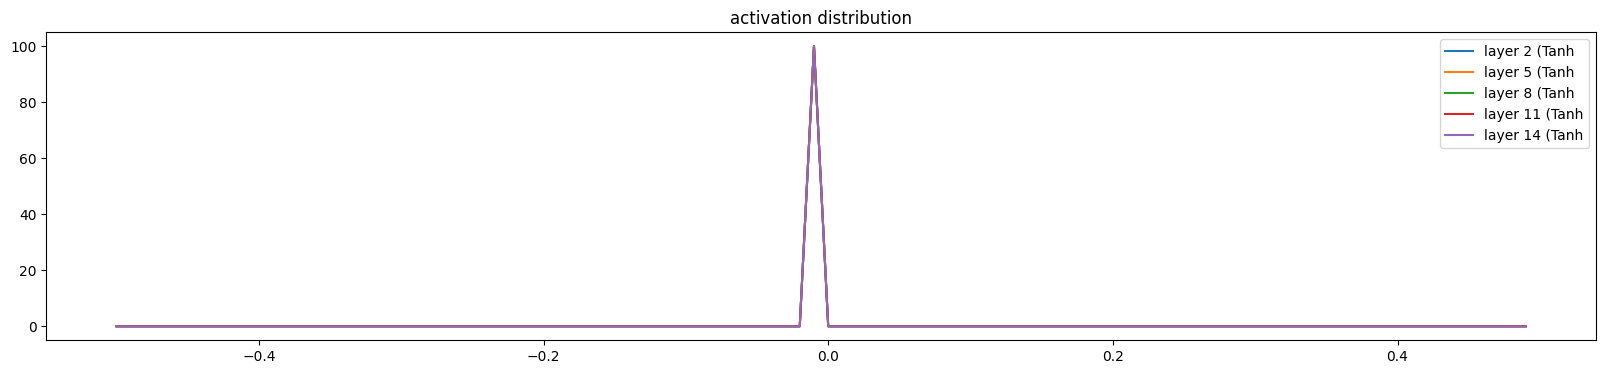

In [ ]:
# Inspect Activations
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

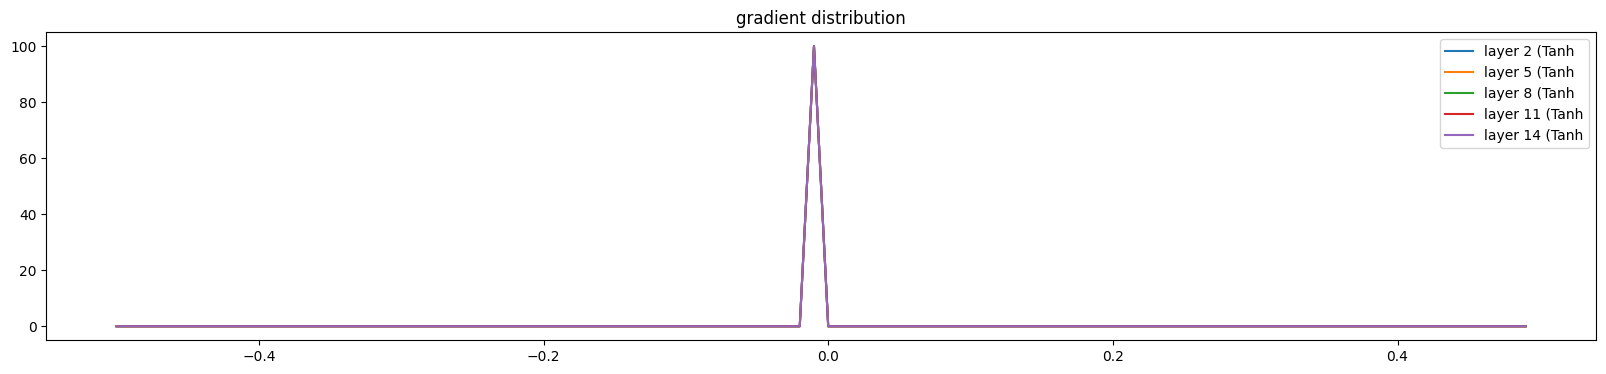

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
parameters

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

The only updates are in the last layer due to the loss calculation. This is where the "partial" training is happening. What I don't get is why none of this "trickles" up.

#### E02

Folding did not work :( I'm definitely making some stupid error here.

In [ ]:
# MLP Setup
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
network = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden)
]

parameters = [C] + [p for layer in network for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

23870


In [ ]:
# MLP Training
batch_size = 32
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
  Xb, Yb = X[ix], Y[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in network:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

In [ ]:
# MLP Eval 1
@torch.no_grad()
def split_loss():
  x, y = X, Y
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in network:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(loss.item())

# put layers into eval mode
for layer in network:
  layer.training = False
split_loss()

2.5595736503601074


In [ ]:
# Fold function
def fold_batchnorm_into_linear(linear, batchnorm):
    batchnorm.training = False

    # Get parameters
    gamma = batchnorm.gamma
    beta = batchnorm.beta
    running_mean = batchnorm.running_mean
    running_var = batchnorm.running_var
    eps = batchnorm.eps
    W = linear.weight
    b = linear.bias if linear.bias is not None else torch.zeros_like(beta)

    # Calculate folded parameters
    scale = gamma / torch.sqrt(running_var + eps)
    W_folded = W * scale
    b_folded = (b - running_mean) * scale + beta

    # Create new linear layer
    folded_linear = Linear(W.shape[0], W.shape[1], bias=True)

    # Assign folded parameters
    folded_linear.weight = W_folded
    folded_linear.bias = b_folded

    return folded_linear

In [ ]:
#folding
import torch.nn as nn

network[0] = fold_batchnorm_into_linear(network[0], network[1])
network[3] = fold_batchnorm_into_linear(network[3], network[4])
network[6] = fold_batchnorm_into_linear(network[6], network[7])
network[2] = nn.Identity()
network[5] = nn.Identity()

parameters = [C] + [p for layer in network for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

24170


In [ ]:
# MLP Eval 2
@torch.no_grad()
def split_loss():
  x, y = X, Y
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in network:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(loss.item())

for layer in network:
  layer.training = False
split_loss()

5.05037784576416
5.05037784576416


I get different losses :(.

### GPT

#### EX2
Took surprisingly longer than I thought (3-4 hours of messing around with different ideas until I actually got something that felt reasonable, and then another 2-3 hours of debugging as I realized that it wasn't reasonable at all). Something still feels off, even though the model does learn. I would expect the model to have been able to overfit 1-digit addition quickly, but even after 60K iterations it still only had close-ish answers and loss couldn't quite get past 0.25.

I did my best to follow the structure of the code AK used in the video, but I have a cleaner version in gptaddition.py.

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import random

# hyperparameters -> convert to dataclass eventually
batch_size = 128
num_digits = 1
block_size = 3*num_digits + 3
max_iters = 50000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.1
vocab_size = 0


vocab = '0123456789+='
vocab_size = len(vocab) + 1
stoi = { ch:i for i,ch in enumerate(vocab) }
itos = { i:ch for i,ch in enumerate(vocab) }
PAD_TOKEN = vocab_size - 1
stoi['P'] = PAD_TOKEN
itos[PAD_TOKEN] = 'P'
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [14]:
# Problem Generation Function
def generate_addition_problem(digits=num_digits):
  num_1 = random.randint(0, 10**digits -1)
  num_2 = random.randint(0, 10**digits -1)

  problem = f"{num_1}+{num_2}="
  answer = str(num_1+num_2)
  if len(answer) < digits + 1:
    answer = '0'+answer
  return problem, answer[::-1]

In [15]:
# Problem Encoding Function
def encode_problem(problem, answer, digits=num_digits):
  y = [-1] * len(problem)
  x = torch.tensor(encode(problem))
  y.extend(encode(answer))
  y = torch.tensor(y)
  return x, y

In [16]:
problem, answer = generate_addition_problem()
problem, answer, encode_problem(problem, answer)

('2+4=', '60', (tensor([ 2, 10,  4, 11]), tensor([-1, -1, -1, -1,  6,  0])))

In [17]:
# Get_Batch Function
def get_batch():
  xs, ys = [], []
  for i in range(batch_size):
    x, y = encode_problem(*generate_addition_problem())
    x = F.pad(x, (0, block_size - len(x)), value=PAD_TOKEN)
    y = F.pad(y, (0, block_size - len(y)), value=-1)
    assert len(x) == len(y) or len(y) == block_size
    xs.append(x)
    ys.append(y)
  x_stack = torch.stack(xs)
  y_stack = torch.stack(ys)
  return x_stack.to(device), y_stack.to(device)

In [18]:
preds, targets = get_batch()

In [19]:
preds[:5], targets[:5]

(tensor([[ 1, 10,  8, 11, 12, 12],
         [ 1, 10,  7, 11, 12, 12],
         [ 9, 10,  7, 11, 12, 12],
         [ 5, 10,  7, 11, 12, 12],
         [ 8, 10,  8, 11, 12, 12]], device='cuda:0'),
 tensor([[-1, -1, -1, -1,  9,  0],
         [-1, -1, -1, -1,  8,  0],
         [-1, -1, -1, -1,  6,  1],
         [-1, -1, -1, -1,  2,  1],
         [-1, -1, -1, -1,  6,  1]], device='cuda:0'))

In [20]:
# Actual Model
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fn(logits, targets)

        return logits, loss

    def generate(self, idx):
        # idx is (B, T) array of indices in the current context
        for _ in range(block_size):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [21]:
# Test Function
def test_generations(model, num_evals = 10):
  for i in range(num_evals):
    problem, answer = generate_addition_problem()
    problem_tensified, _ = encode_problem(problem, answer)
    out = model.generate(problem_tensified.unsqueeze(0).to(device))
    out = decode([int(x) for x in out[0].tolist()])[len(problem):]
    print(f"Problem: {problem} | Output: {out[:num_digits+1][::-1]}")

In [22]:
# Define model
model = GPTLanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [27]:
# Train Loop -> trained for a total of 110k iterations
for iteration in range(max_iters):
  if iteration % eval_interval == 0:
    model.eval()
    losses = []
    with torch.no_grad():
      for _ in range(eval_iters):
        for k in range(eval_iters):
            X, Y = get_batch()
            logits, loss = model(X, Y)
            losses.append(loss.item())
    model.train()
    mean_loss = torch.mean(torch.tensor(losses))
    print(f"step {iteration}: loss {mean_loss:.4f}")
    xb, yb = get_batch()

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: loss 0.2159
step 500: loss 0.2092
step 1000: loss 0.2287
step 1500: loss 0.2375
step 2000: loss 0.2121
step 2500: loss 0.2127
step 3000: loss 0.2018
step 3500: loss 0.2700
step 4000: loss 0.2651
step 4500: loss 0.1925
step 5000: loss 0.1996
step 5500: loss 0.2307
step 6000: loss 0.2729
step 6500: loss 0.2664
step 7000: loss 0.2211
step 7500: loss 0.2293
step 8000: loss 0.1942
step 8500: loss 0.1956
step 9000: loss 0.2272
step 9500: loss 0.2184


In [28]:
test_generations(model)

Problem: 7+6= | Output: 41
Problem: 8+7= | Output: 41
Problem: 9+2= | Output: 11
Problem: 4+8= | Output: 21
Problem: 3+0= | Output: 40
Problem: 1+9= | Output: 00
Problem: 1+3= | Output: 40
Problem: 2+5= | Output: 70
Problem: 2+1= | Output: 30
Problem: 8+9= | Output: 80


It kinda works?

#### EX3

#### EX4